In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from IPython.display import Image

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# To make this notebook's output stable across runs
np.random.seed(42)

# Plotting setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("../images", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Load the dataset
df = pd.read_csv("harry_potter_students_20000.csv")
df.head()

,Blood Status,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity,House
0,Pure-blood,NaN,NaN,NaN,NaN,7.0,NaN,8.0,NaN,NaN
1,Muggle-born,3.0,7.0,6.0,2.0,5.0,3.0,3.0,10.0,Ravenclaw
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Muggle-born,2.0,9.0,1.0,2.0,3.0,0.0,5.0,8.0,Ravenclaw
4,NaN,NaN,NaN,9.0,2.0,NaN,1.0,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Blood Status         15059 non-null  object 
 1   Bravery              15043 non-null  float64
 2   Intelligence         15019 non-null  float64
 3   Loyalty              15088 non-null  float64
 4   Ambition             15005 non-null  float64
 5   Dark Arts Knowledge  14964 non-null  float64
 6   Quidditch Skills     15089 non-null  float64
 7   Dueling Skills       15038 non-null  float64
 8   Creativity           14995 non-null  float64
 9   House                15049 non-null  object 
dtypes: float64(8), object(2)
memory usage: 1.5+ MB
None

Missing values per column:
Blood Status           4941
Bravery                4957
Intelligence           4981
Loyalty                4912
Ambition               4995
Dark Arts Knowledge    5036
Quidditch Skills       4911
Dueling Sk

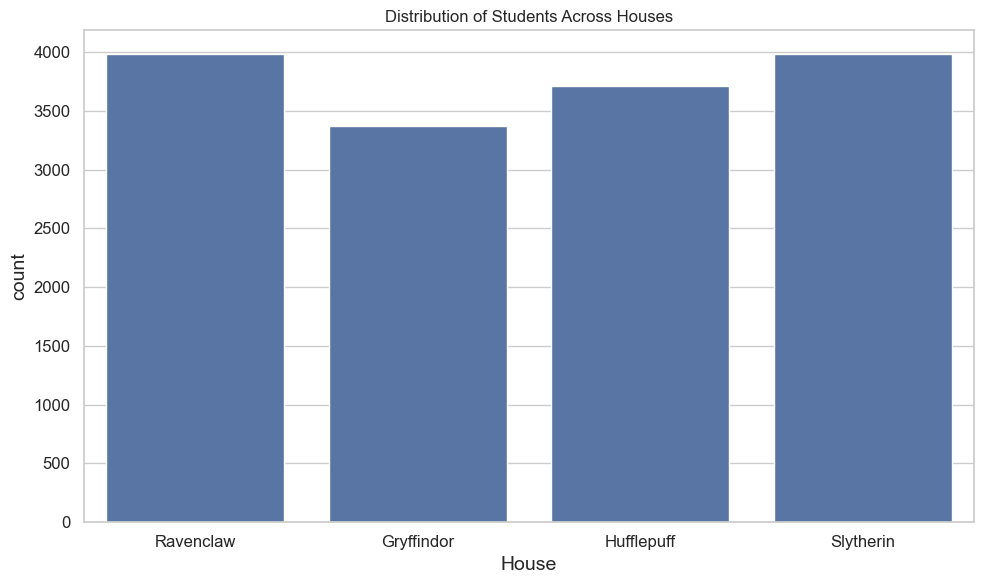

In [3]:
# Basic info
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# House distribution
plt.figure(figsize=(10,6))
sns.countplot(x='House', data=df)
plt.title("Distribution of Students Across Houses")
save_fig("house_distribution")
plt.show()

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df.drop('House', axis=1)
y = df['House']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64']).columns
categorical_cols = ['Blood Status']

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Compute correlations with houses (after encoding)
from sklearn.preprocessing import LabelEncoder

# Encode houses numerically for correlation analysis
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create a temporary dataframe with encoded houses
temp_df = X.copy()
temp_df['House'] = y_encoded

# Handle missing values temporarily for correlation analysis
temp_df = temp_df.fillna(temp_df.median())

# Compute correlations
correlations = temp_df.corr()['House'].sort_values(ascending=False)
print("\nFeature correlations with House:")
print(correlations)

# Plot top correlated features
plt.figure(figsize=(10,6))
correlations.drop('House').plot.bar()
plt.title("Feature Correlations with House")
save_fig("feature_correlations")
plt.show()

TypeError: Cannot convert [['Pure-blood' 'Muggle-born' nan ... 'Half-blood' 'Pure-blood'
  'Half-blood']] to numeric

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define models
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('KNN', KNeighborsClassifier())
]

# Evaluate each model using cross-validation
results = []
for name, model in models:
    # Create full pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Get cross-validation scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    results.append((name, cv_scores.mean(), cv_scores.std()))

    print(f"{name}: {cv_scores.mean():.3f} accuracy (±{cv_scores.std():.3f})")

# Convert results to dataframe
results_df = pd.DataFrame(results, columns=['Model', 'Mean Accuracy', 'Std'])
results_df = results_df.sort_values('Mean Accuracy', ascending=False)

TypeError: '<' not supported between instances of 'float' and 'str'

In [7]:
# Plot model performance
plt.figure(figsize=(10,6))
sns.barplot(x='Mean Accuracy', y='Model', data=results_df, xerr=results_df['Std'])
plt.title("Model Comparison (Cross-Validation Accuracy)")
plt.xlim(0, 1)
save_fig("model_comparison")
plt.show()

NameError: name 'results_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [8]:
from sklearn.model_selection import GridSearchCV

# Best model appears to be Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(random_state=42))])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel('True House')
plt.xlabel('Predicted House')
save_fig("confusion_matrix")
plt.show()

In [ ]:
# Get feature names after preprocessing
preprocessor.fit(X)
feature_names = (numerical_cols.tolist() +
                 list(preprocessor.named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names(categorical_cols)))

# Get feature importances from the best model
importances = best_model.named_steps['classifier'].feature_importances_

# Create dataframe
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Most Important Features")
save_fig("feature_importance")
plt.show()